# Generative Adversarial Network (GAN) - Monet Painting Generation

## Project Description

### Overview
This notebook contains the code for the following Kaggle competition: Jang, A., Uzsoy, A. S., & Culliton, P. (2020). *I’m something of a painter myself*. Kaggle. https://kaggle.com/competitions/gan-getting-started.

### Goal
The goal of this project is to build a GAN to generate 7'000 to 10'000 Monet-style images from pictures and submit the results.

### Data: size, structure, dimension

The data for this project consists of
- 300 Monet-style images (256x256) in JPEG and TFRecord format
- 7028 phtos in JPEG and TFRecord format.

### Method: Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are a deep learning framework designed to generate data from scratch, such as images, music, and beyond. GANs consist of two competing neural networks: the generator, which creates data, and the discriminator, which evaluates it for authenticity. Through an iterative process, these networks refine each other, with the generator aiming to produce data indistinguishable from real samples and the discriminator improving its ability to differentiate real from generated data. GANs have diverse applications, from creating realistic images (e.g., transforming photos into Monet-style paintings) to accelerating reinforcement learning. Despite their promise, challenges like vanishing gradients and ethical concerns about misuse accompany their immense potential. [1]


## Imports and data handling on Colab

In [1]:
import os
import time
import zipfile
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/DTSA-Project-Final/'
drive_contents = os.listdir(path)
drive_contents

['gan-getting-started.zip', 'final-project.ipynb', 'images.zip']

In [4]:
import shutil

# Copy the file from Google Drive to Colab
source_path = path + 'gan-getting-started.zip'
destination_path = '/content/gan-getting-started.zip'

shutil.copy(source_path, destination_path)
print("File copied successfully.")

File copied successfully.


In [5]:
import zipfile

# Unpack zip file
destination_folder = '/content/gan-getting-started/'
with zipfile.ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("Zip file extracted successfully.")

Zip file extracted successfully.


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

### EDA

#### Load and preview images

In [6]:
# Code snippet from https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training

MONET_FILENAMES = tf.io.gfile.glob(str('gan-getting-started' + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str('gan-getting-started' + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [7]:
# Code snippet from https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training

AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

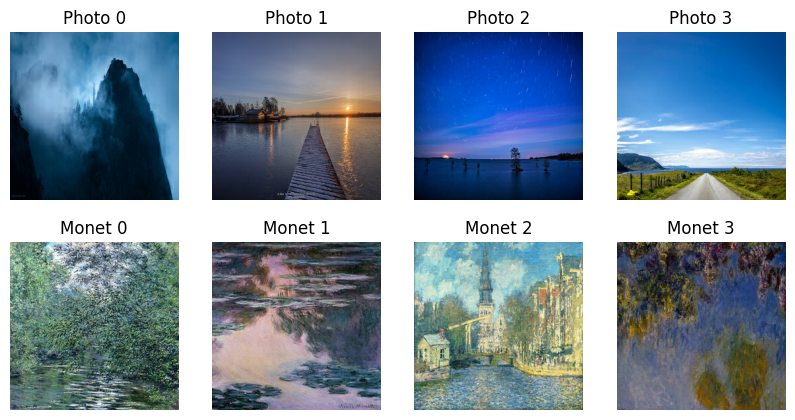

In [8]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

monet_examples = [image for image in monet_ds.take(4)]
photo_examples = [image for image in photo_ds.take(4)]

plt.figure(figsize=(10, 5))

for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.title('Photo ' + str(i))
    plt.imshow(photo_examples[i][0] * 0.5 + 0.5)
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    plt.title('Monet ' + str(i))
    plt.imshow(monet_examples[i][0] * 0.5 + 0.5)
    plt.axis('off')

plt.show()

#### Color channels - comparison photo and monet

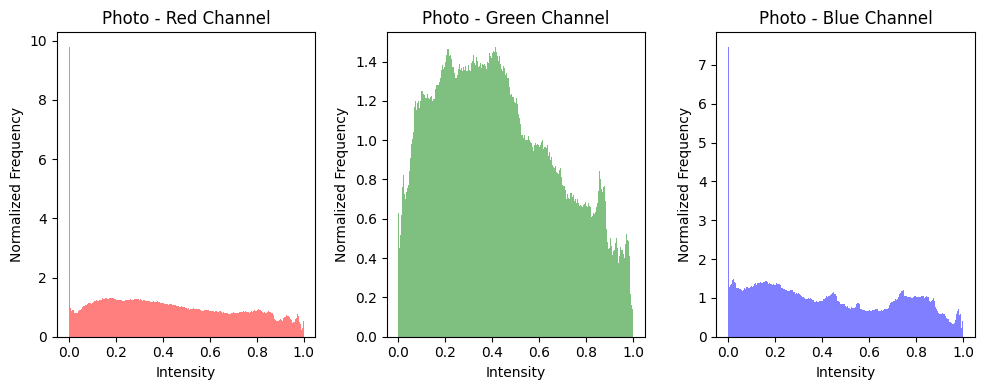

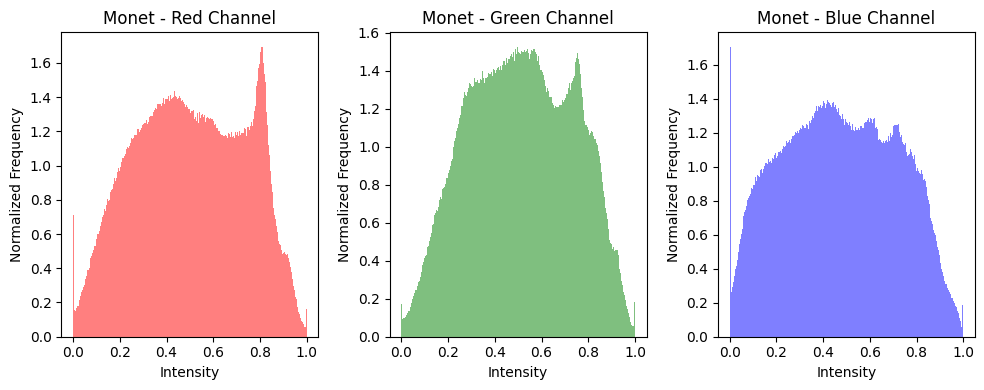

In [9]:
# Part of the code in the following cells was generated with the assistance of GitHub Copilot, an AI programming assistant.

def accumulate_histogram(dataset, num_samples=30):
    red_channel = []
    green_channel = []
    blue_channel = []

    for image in dataset.take(num_samples):
        image = image[0].numpy() * 0.5 + 0.5
        red_channel.extend(image[:, :, 0].ravel())
        green_channel.extend(image[:, :, 1].ravel())
        blue_channel.extend(image[:, :, 2].ravel())

    return red_channel, green_channel, blue_channel

def plot_average_histogram(red_channel, green_channel, blue_channel, title):
    num_pixels = len(red_channel)

    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.hist(red_channel, bins=256, color='red', alpha=0.5, density=True)
    plt.title(f'{title} - Red Channel')
    plt.xlabel('Intensity')
    plt.ylabel('Normalized Frequency')

    plt.subplot(132)
    plt.hist(green_channel, bins=256, color='green', alpha=0.5, density=True)
    plt.title(f'{title} - Green Channel')
    plt.xlabel('Intensity')
    plt.ylabel('Normalized Frequency')

    plt.subplot(133)
    plt.hist(blue_channel, bins=256, color='blue', alpha=0.5, density=True)
    plt.title(f'{title} - Blue Channel')
    plt.xlabel('Intensity')
    plt.ylabel('Normalized Frequency')

    plt.tight_layout()
    plt.show()

photo_red, photo_green, photo_blue = accumulate_histogram(photo_ds)
monet_red, monet_green, monet_blue = accumulate_histogram(monet_ds)

plot_average_histogram(photo_red, photo_green, photo_blue, 'Photo')
plot_average_histogram(monet_red, monet_green, monet_blue, 'Monet')


#### Check if all images are 256x256

In [10]:
def get_image_sizes(dataset):
    sizes = []
    for image in dataset:
        sizes.append(image.shape)
    return sizes

monet_sizes = get_image_sizes(monet_ds)
photo_sizes = get_image_sizes(photo_ds)

monet_sizes = [(size[1], size[2]) for size in monet_sizes]
photo_sizes = [(size[1], size[2]) for size in photo_sizes]

# Check if all sizes are 256x256
def check_all_sizes(sizes, expected_size=(256, 256)):
    all_correct = True
    for size in sizes:
        if size != expected_size:
            all_correct = False
            print(f"Incorrect size found: {size}")
    return all_correct

all_monet_images_correct_size = check_all_sizes(monet_sizes)
print("All Monet images are 256x256:", all_monet_images_correct_size)

all_photo_images_correct_size = check_all_sizes(photo_sizes)
print("All Photo images are 256x256:", all_photo_images_correct_size)

All Monet images are 256x256: True
All Photo images are 256x256: True


### EDA Summary
- The images and the data was loaded and previewed
- The average intesities of the color channels of monet paintings are visibly distinct from photos, which was expected
- All pictures are in the expected 256X256 foramt

### Data Cleaning
- No further data cleaning is required

### Plan of Analysis
- No further pre-processing is required
- In the next section, the model architecture is developed
- The model is then trained and fit to create the pictures for submission

## Model Architecture

### Generator

The architecture draws from principles established in the DCGAN paper [2], particularly the use of Conv2D layers in the encoder for hierarchical feature extraction and Conv2DTranspose layers in the decoder for upsampling, the application of BatchNormalization after convolutional layers, and the choice of tanh activation in the output layer to normalize pixel values to the range [-1, 1].

#### Encoder
The down stack progressively reduces the spatial dimensions while increasing the feature depth:
1. **Conv2D (64 filters, kernel size=4, strides=2):** Extracts features and downsamples the input.
2. **BatchNormalization:** Normalizes the feature maps for faster convergence.
3. **LeakyReLU:** Applies activation with a slight slope for negative values.
4. Repeats the above steps for:
   - 128 filters
   - 256 filters
   - 512 filters

#### Decoder
The up stack progressively upsamples the feature maps to restore spatial dimensions:
1. **Conv2DTranspose (256 filters, kernel size=4, strides=2):** Upsamples the feature maps.
2. **BatchNormalization:** Normalizes the feature maps.
3. **ReLU:** Applies the activation function.
4. Repeats the above steps for:
   - 128 filters
   - 64 filters
5. **Conv2DTranspose (3 filters, kernel size=4, strides=2, activation='tanh'):** Outputs a 3-channel image with values scaled to [-1, 1].

#### Output
- **Shape:** [256, 256, 3] (same as the input shape)
- **Activation:** `tanh` to normalize the output pixel values to the range [-1, 1].

#### Alternative architecture for comparison

Two architectures are tested for this project:

| **Layer Type**              | **Architecture 1**               | **Architecture 2**             |
|-----------------------------|--------------------------------------------|------------------------------------------|
| **Conv2D (1st Down Layer)**  | 64 filters, kernel size=4, strides=2, padding='same' | 128 filters, kernel size=5, strides=2, padding='same' |
| **Conv2D (2nd Down Layer)**  | 128 filters, kernel size=4, strides=2, padding='same' | 256 filters, kernel size=5, strides=2, padding='same' |
| **Conv2D (3rd Down Layer)**  | 256 filters, kernel size=4, strides=2, padding='same' | 512 filters, kernel size=5, strides=2, padding='same' |
| **Conv2D (4th Down Layer)**  | 512 filters, kernel size=4, strides=2, padding='same' | 1024 filters, kernel size=5, strides=2, padding='same' |
| **Conv2DTranspose (1st Up Layer)** | 256 filters, kernel size=4, strides=2, padding='same' | 512 filters, kernel size=5, strides=2, padding='same' |
| **Conv2DTranspose (2nd Up Layer)** | 128 filters, kernel size=4, strides=2, padding='same' | 256 filters, kernel size=5, strides=2, padding='same' |
| **Conv2DTranspose (3rd Up Layer)** | 64 filters, kernel size=4, strides=2, padding='same' | 128 filters, kernel size=5, strides=2, padding='same' |
| **Conv2DTranspose (Output Layer)** | 3 filters, kernel size=4, strides=2, padding='same', activation='tanh' | 3 filters, kernel size=5, strides=2, padding='same', activation='tanh' |
| **Activation Function (Down Layers)** | LeakyReLU | LeakyReLU (alpha=0.2) |
| **Activation Function (Up Layers)** | ReLU | ReLU |


The changes involve increasing the number of filters in both the downsampling and upsampling layers to capture more complex features, and using larger kernel sizes (5 instead of 4) for better detail extraction. Additionally, the LeakyReLU activation function’s alpha value was adjusted to 0.2 to improve gradient flow during training.

In [11]:
# Part of the code in the following cells was generated with the assistance of GitHub Copilot, an AI programming assistant.

# Generator model: architecture 1
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(512, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
    ]

    up_stack = [
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(3, 4, strides=2, padding='same', use_bias=False, activation='tanh'),
    ]

    x = inputs
    for down in down_stack:
        x = down(x)

    for up in up_stack:
        x = up(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# Alternative generator model (architecture 2)
"""
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        layers.Conv2D(128, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1024, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
    ]

    up_stack = [
        layers.Conv2DTranspose(512, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(256, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(3, 5, strides=2, padding='same', use_bias=False, activation='tanh'),
    ]

    x = inputs
    for down in down_stack:
        x = down(x)

    for up in up_stack:
        x = up(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
"""

### Discriminator

The discriminator is a CNN designed to classify real and fake images by progressively downsampling the input image. This discriminator architecture is inspired by the PatchGAN approach introduced in [3], where the network classifies patches of an image as real or fake rather than the entire image. The progressive downsampling through convolutional layers followed by a final single-channel output aligns with the PatchGAN design for local image classification, making it suitable for image-to-image translation tasks.

#### Layers
1. **Conv2D (64 filters, kernel size=4, strides=2)**: Extracts low-level features.
   - Activation: **LeakyReLU**
   
2. **Conv2D (128 filters, kernel size=4, strides=2)**: Extracts higher-level features.
   - BatchNormalization, **LeakyReLU**
   
3. **Conv2D (256 filters, kernel size=4, strides=2)**: Further feature extraction.
   - BatchNormalization, **LeakyReLU**
   
4. **Conv2D (512 filters, kernel size=4, strides=1)**: Deep feature extraction.
   - BatchNormalization, **LeakyReLU**
   
5. **Conv2D (1 filter, kernel size=4, strides=1)**: Outputs a real/fake prediction.

#### Output
- **Shape:** Single-channel prediction (real or fake).
- **Purpose:** Classifies the input image at the patch level, typical for **PatchGAN**.


In [12]:
def build_discriminator():
    inputs = layers.Input(shape=[256, 256, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Model Compliation

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return loss

generator_g = build_generator()
generator_f = build_generator()

discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Hyperparameter Tuning
An alternative set of hyperparameters is tested for Model Architecture 1 to evaluate its effect on the score.

In [ ]:
# Alternative set of hyperparameters
"""
generator_g_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.4)
generator_f_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.4)

discriminator_x_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.4)
discriminator_y_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.4)
"""

### Model Training

In [14]:
import os
import time
from IPython import display

EPOCHS = 50
BUFFER_SIZE = 1000
BATCH_SIZE = 8

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

def train(dataset_x, dataset_y, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_x, image_y in tf.data.Dataset.zip((dataset_x, dataset_y)):
            train_step(image_x, image_y)

        display.clear_output(wait=True)
        generate_and_save_images(generator_g, epoch + 1, sample_photo)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    display.clear_output(wait=True)
    generate_and_save_images(generator_g, epochs, sample_photo)

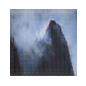

In [15]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] * 0.5 + 0.5).numpy())
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

sample_photo = next(iter(photo_ds))

# Use smaller sample for testing purposes
# photo_ds_subset = photo_ds.take(100)
# monet_ds_subset = monet_ds.take(100)

train(photo_ds, monet_ds, EPOCHS)

### Generate and save images

In [ ]:
def generate_images(model, dataset, num_images):
    generated_images = []
    for image in dataset.take(num_images):
        generated_image = model(image, training=False)
        generated_images.append(generated_image)
    return generated_images

# Generate images
generated_images = generate_images(generator_g, photo_ds, 7500)

# Path for the zip file
zip_path = '/content/drive/MyDrive/DTSA-Project-Final/images.zip'

# Save images directly into a zip file
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for i, img in enumerate(generated_images):
        # Convert the image to a NumPy array and rescale to [0, 1]
        img_array = (img[0] * 0.5 + 0.5).numpy()
        
        # Save the image to a buffer
        from io import BytesIO
        buffer = BytesIO()
        plt.imsave(buffer, img_array, format='png')
        buffer.seek(0)
        
        # Write the image buffer to the zip file
        zipf.writestr(f'generated_image_{i+1}.png', buffer.read())

print(f"Images are saved directly to the zip file at {zip_path}")

## Results and Analysis

### Result table: comparison of model architecture 1 and 2

| Model | Result (Score Kaggle) |
|----------|----------|
| Architecture 1 | 92.92 |
| Architecture 1 - tuning | 103.49 |
| Architecture 2 | 100.84 |

Architecture 2 performed slightly worse than architecture 1. The modified architecture's increased complexity may have led to overfitting, as the model's larger capacity required more data or careful regularization to perform well. Additionally, the larger kernel sizes may have altered how the network processed spatial information, leading to suboptimal results compared to the simpler original architecture.


### Summary hyperparameter tuning

The hyperparameters were adjusted by increasing the learning rate to 3e-4 and modifying the beta_1 value to 0.4, which may have caused the optimizer to overshoot optimal minima and weakened the momentum, resulting in unstable or suboptimal training dynamics.

### Evaluation hyperparameter tuning and model architecture

Hyperparameter tuning did not improve the performance of Architecture 1, as it resulted in a higher score. Similarly, the modifications to Architecture 2 led to a slightly worse score, indicating that the original architecture and default hyperparameters were better suited for the dataset.

## References
[1] Hui, J. (2018, June 19). *GAN - What’s Generative Adversarial Networks and its application*. Medium. Retrieved January 18, 2025, from [https://jonathan-hui.medium.com/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09](https://jonathan-hui.medium.com/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09).

[2] Radford, A., Metz, L., & Chintala, S. (2015). *Unsupervised representation learning with deep convolutional generative adversarial networks*. arXiv. https://arxiv.org/abs/1511.06434.

[3] Isola, P., Zhu, J. Y., Zhou, T., & Efros, A. A. (2017). *Image-to-image translation with conditional adversarial networks*. arXiv. https://arxiv.org/abs/1611.07004

[4] Jang, A., Uzsoy, A. S., & Culliton, P. (2020). *I’m something of a painter myself*. Kaggle. https://kaggle.com/competitions/gan-getting-started.

**AI attribution: This work was supported by GitHub Copilot, an AI-powered code completion tool, which assisted in generating code snippets and providing suggestions during the development process.**